# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# 1. Import libraries and create Spark session

In [70]:
import pyspark
import numpy as np
import seaborn as sns
import re
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType,DoubleType, LongType
from pyspark.sql.window import Window
from pyspark.sql.functions import  desc, explode, lit, split, udf,count, avg, col, concat\
,mean,when,lead,isnan,countDistinct,month,from_unixtime,datediff,to_timestamp
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
import pandas as pd
import scipy.stats as stats

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("EDA") \
    .getOrCreate()

# 2. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 2.1 Load data and check columns

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema() # check categories/columns 

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#user_df.write.save("user_df2.csv",format='csv')

In [5]:
df_data = pd.DataFrame(df.take(5), columns=df.columns)
df_data.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [19]:
# df.describe().show() # check statistics, but overall statistcis doesn't give too much information 

In [32]:
# select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','itemInSession','level' ,'location','method','page','status']:
        df.groupBy(str(col.name)).count().show() #understand the meaning of columns 

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

## 2.2 Check for null values

In [101]:
for s in df.columns:
    print(s,':',df.filter(df[s].isNull()).count())
    

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [116]:
df.select('userId').distinct().sort("userId").show(), df.select('sessionId').distinct().sort("sessionId").show() #userid has blank values 

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



(None, None)

In [5]:
# dropna with userid and sessionid 
df = df.filter(df['userId']!='')
df.filter(df.userId == '').count(),df.filter(df.sessionId == '').count()

(0, 0)

In [6]:
df.select('userId').distinct().count() # there are 225 users 

225

# 3. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### 3.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [7]:
df=df.withColumn('churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0))
#df_churn = df.join(churn_df, on='userId')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)



In [8]:
df.select('length','userId').show()

+---------+------+
|   length|userId|
+---------+------+
|277.89016|    30|
|236.09424|     9|
| 282.8273|    30|
|262.71302|     9|
|223.60771|    30|
|208.29995|     9|
|260.46649|     9|
|185.44281|    30|
|     null|    30|
|134.47791|    30|
| 229.8771|     9|
|     null|     9|
|223.58159|    30|
|201.06404|     9|
|     null|     9|
|246.69995|    30|
|168.64608|     9|
| 166.1122|    74|
|222.22322|    30|
|229.77261|     9|
+---------+------+
only showing top 20 rows



In [9]:
df.filter(df.churn == 1).select('userID').distinct().count()/225 #churn rate

0.2311111111111111

### 3.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Following are possible factors that might contribute to churn behavior:

1. artist count
2. song count 
3. average session length
4. largest gap between visits  
5. session counts 
6. cancellation page count  
7. gender 
8. location 
9. level 
10. total length of visit 
11. total registration days 
12. session frequency: session count/registration days 

In [10]:
# explore factors that might contribute to churn on user level 
# build base user_df
user_df = df.groupBy('userId').agg(F.max('churn')).withColumnRenamed("max(churn)", "churn")
user_df.count()

225

#### 3.2.1 Engineer features

In [11]:
# gender to int
int_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df = df.withColumn('int_gender',int_gender('gender'))
genderdf = df.groupBy('userId').agg(F.max('int_gender')).withColumnRenamed('max(int_gender)','gender')
user_df=user_df.join(genderdf, ['userId'])

In [12]:
# level to int
int_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df = df.withColumn('int_level',int_level('level'))
leveldf = df.groupBy('userId').agg(F.max('int_level')).withColumnRenamed('max(int_level)','level')
user_df = user_df.join(leveldf,['userId'])

In [13]:
# artist count 
artist_count = df.groupBy('userId').agg(countDistinct('artist')).withColumnRenamed('count(DISTINCT artist)','artist_count')
user_df=user_df.join(artist_count, ['userId'])

In [14]:
# song count 
song_count = df.groupBy('userId').agg(countDistinct('song')).withColumnRenamed('count(DISTINCT song)','song_count')
user_df=user_df.join(song_count, ['userId'])

In [15]:
# average session length 
length_mean = df.groupBy('userId').agg(mean('length')).withColumnRenamed('mean(length)','length_mean')
user_df=user_df.join(length_mean, ['userId'])

In [16]:
# total session counts 
session_count = df.groupBy('userId').agg(count('sessionId')).withColumnRenamed('count(sessionId)','session_count')
user_df=user_df.join(session_count, ['userId'])

In [17]:
# total cancellation page counts 
import pyspark.sql.functions as F     
count_cancel = udf(lambda x: 1 if x == 'Cancel' else 0, IntegerType())
df = df.withColumn('is_cancel',count_cancel('page'))
cancel_count = df.groupBy('userId').agg(F.sum('is_cancel')).withColumnRenamed('sum(is_cancel)','cancel_count')
user_df=user_df.join(cancel_count, ['userId'])

In [18]:
# localtion 
location_df = df.select('userId','location').dropDuplicates(['userId'])
# simplify location to state level 
location_df = location_df.withColumn('location', split(col('location'),',').getItem(1))
user_df=user_df.join(location_df, ['userId'])

In [19]:
# total length of visit 
total_length = df.groupBy('userId').agg(F.sum('length')).withColumnRenamed('sum(length)','total_length')
user_df=user_df.join(total_length, ['userId'])


In [20]:
# longest visit gap
def calc_gap(x):
    '''
    calculate largest time gap between user's sessions 
    parameters:
    input: list x (sorted ascending)
    output: a number gap that's the largest difference between neighbors in x
    
    '''
    x.sort()
    gap_list = []
    if len(x)>1:
        for i in range(len(x)-2):
            gap_list.append(x[i+1]-x[i])
    gap = max(gap_list)
    if len(x) == 1:
        gap = 0
    return gap

df2 = df.withColumn('ts2',col('ts')/86400000)
df_ts = df2.groupby('userId').agg(F.collect_list('ts2'))
calc_gap_udf = udf(calc_gap,DoubleType())    
df_gap = df_ts.withColumn('max_gap',calc_gap_udf('collect_list(ts2)'))
user_df=user_df.join(df_gap.select('userId','max_gap'), ['userId'])

In [21]:
# reg_length: time since registration 
df_latest = df.select('userId','ts').groupBy('userId').agg(F.max('ts')).withColumnRenamed('max(ts)','max_ts')
df_reg = df.select('userId','registration').groupby('userId').agg(F.min('registration'))
df_latest = df_latest.join(df_reg,['userId'])
df_reg_length = df_latest.withColumn('reg_days',(col('max_ts')-col('min(registration)'))/86400000)
user_df=user_df.join(df_reg_length.select('userId','reg_days'), ['userId'])

In [22]:
# session frequency: session count/reg_days 
user_df = user_df.withColumn('se_freq',col('session_count')/col('reg_days'))

In [23]:
# avg item number in sessions 
avg_session_items = df.groupby('userId').agg(F.avg('itemInSession')).withColumnRenamed('avg(itemInSession)', 'avg_session_items')
user_df = user_df.join(avg_session_items,['userId'])

In [24]:
# avg session_length in sessions 
avg_length = df.groupby('userId').agg(F.avg('length')).withColumnRenamed('avg(length)', 'avg_length')
user_df = user_df.join(avg_length,['userId'])

In [25]:
# total session_length in sessions 
sum_length = df.groupby('userId').agg(F.sum('length')).withColumnRenamed('sum(length)', 'sum_length')
user_df = user_df.join(sum_length,['userId'])

In [26]:
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- avg(length): double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- cancel_count: long (nullable = true)
 |-- location: string (nullable = true)
 |-- total_length: double (nullable = true)
 |-- max_gap: double (nullable = true)
 |-- reg_days: double (nullable = true)
 |-- se_freq: double (nullable = true)
 |-- avg_session_items: double (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- sum_length: double (nullable = true)



#### 3.2.2 Plot figures

In [103]:
def count_plot(df,col):
    '''
    plot comparison for binary variables 
    Input:
    df: pyspark dataframe 
    col: columns to plot 
    '''
    pd = df.select('userId','churn',col).toPandas()
    sns.countplot(x = col,hue = 'churn',data = pd, palette= 'husl')
    
def box_plot(df,col):
    """
    prints boxplot of input col
    Input 
    df: spark DataFrame
    ylabel : column whose values are to be measured
    Output :
    None
    """
    pd = df.select('userId','churn',col).toPandas()
    sns.boxplot(x='churn', y=col, data=pd,palette= 'husl');
    
def plot_location(df,col):
    '''
    plot comparison for binary variables 
    Input:
    df: pyspark dataframe 
    col: columns to plot 
    '''
    pd = df.select('userId','churn',col).toPandas()
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    sns.countplot(x = col,hue = 'churn',data = pd, palette= 'husl')
    plt.xticks(rotation=90)
    
def t_test(df,col1,col2,equal_var):
    '''
    ttest of independent two samples  
    Input:
    df: pyspark dataframe 
    col: columns to perform ttest 
    '''
    pd = df.select(col1,col2).toPandas()
    a = pd[col1][pd[col2]==1]
    b = pd[col1][pd[col2]==0]
    print(stats.ttest_ind(a=a,b=b,equal_var=equal_var))

Ttest_indResult(statistic=-1.2790615609162541, pvalue=0.20220473677306955)


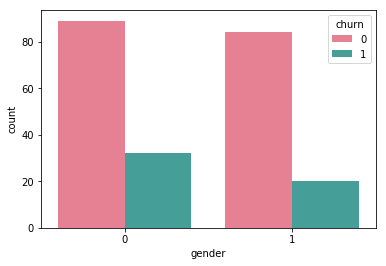

In [71]:
count_plot(user_df,'gender')
t_test(user_df,'gender','churn',True)

Ttest_indResult(statistic=-0.76052560079396359, pvalue=0.44774383896526881)
Ttest_indResult(statistic=-0.76052560079396359, pvalue=0.44774383896526881)


(None, None)

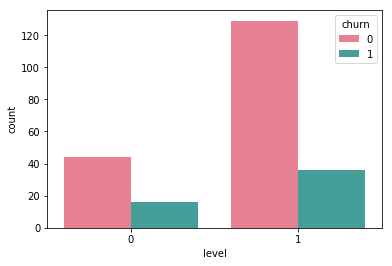

In [72]:
count_plot(user_df,'level')
t_test(user_df,'churn','level',True),t_test(user_df,'churn','level',False)

Ttest_indResult(statistic=-2.4462344850122135, pvalue=0.015209940339497649)


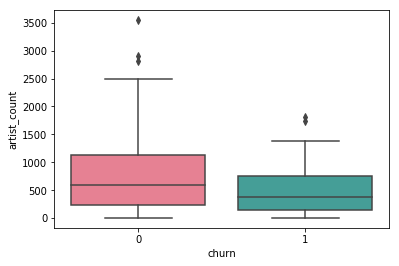

In [73]:
box_plot(user_df,'artist_count') #further statistical analysis?
t_test(user_df,'artist_count','churn',True)

Ttest_indResult(statistic=-2.4053456615058209, pvalue=0.016973210934967127)


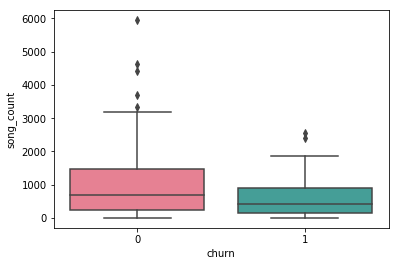

In [82]:
box_plot(user_df,'song_count')
t_test(user_df,'song_count','churn',True)

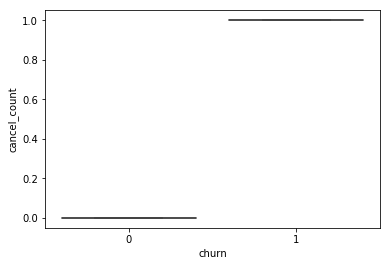

In [104]:
box_plot(user_df,'cancel_count') # this feature is basically a alias with churn, abandon 

Ttest_indResult(statistic=-2.3328782065735796, pvalue=0.020545334721997797)


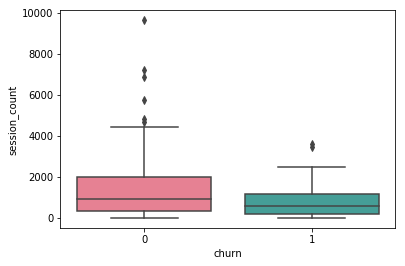

In [74]:
box_plot(user_df,'session_count')
t_test(user_df,'session_count','churn',True)

Ttest_indResult(statistic=-0.88644817737172454, pvalue=0.37633101851790407)


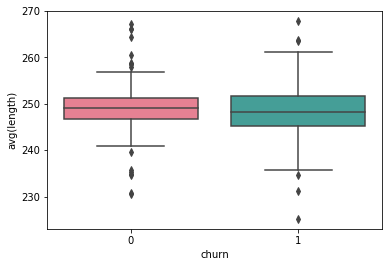

In [75]:
box_plot(user_df,'avg(length)')
t_test(user_df,'avg(length)','churn',True)

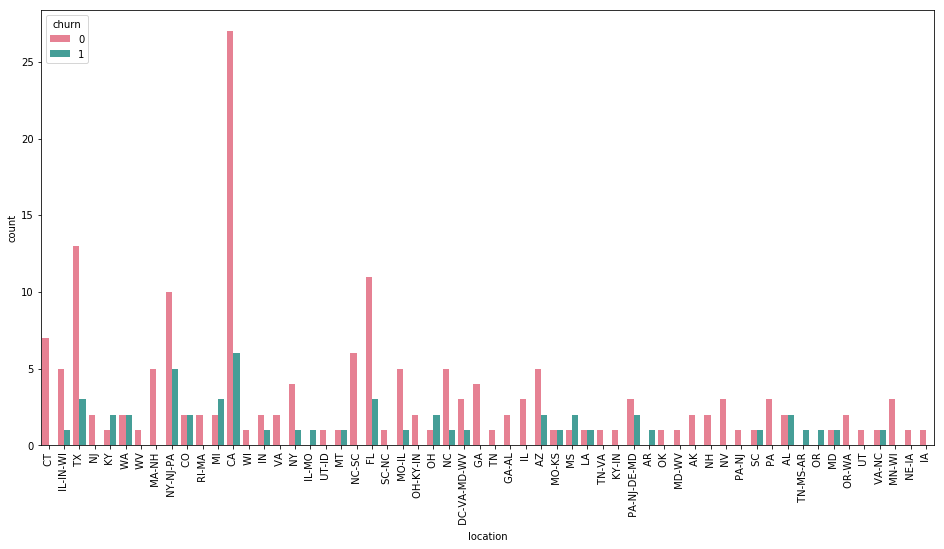

In [150]:
plot_location(user_df,'location')

Ttest_indResult(statistic=-5.1179006515599923, pvalue=6.6622427413638166e-07)
Ttest_indResult(statistic=-5.1179006515599923, pvalue=6.6622427413638166e-07)


(None, None)

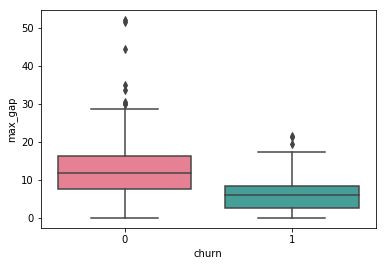

In [76]:
box_plot(user_df,'max_gap')
t_test(user_df,'max_gap','churn',True),t_test(user_df,'max_gap','churn',False),

Ttest_indResult(statistic=0.69335312678729666, pvalue=0.48880949218844072)
Ttest_indResult(statistic=0.69335312678729666, pvalue=0.48880949218844072)


(None, None)

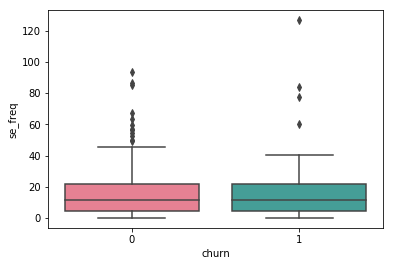

In [77]:
box_plot(user_df,'se_freq')
t_test(user_df,'se_freq','churn',True),t_test(user_df,'se_freq','churn',False)

Ttest_indResult(statistic=-5.1999725267949124, pvalue=4.5041425910754789e-07)
Ttest_indResult(statistic=-5.1999725267949124, pvalue=4.5041425910754789e-07)


(None, None)

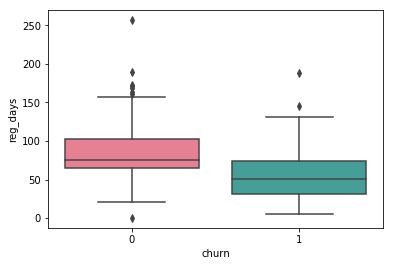

In [78]:
box_plot(user_df,'reg_days')
t_test(user_df,'reg_days','churn',True),t_test(user_df,'reg_days','churn',False)

Ttest_indResult(statistic=-1.8312627354860118, pvalue=0.068395543863040587)
Ttest_indResult(statistic=-1.9583013897632282, pvalue=0.053165860856519288)


(None, None)

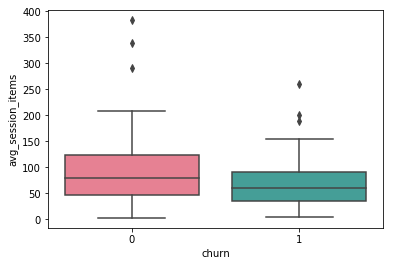

In [108]:
box_plot(user_df,'avg_session_items')
t_test(user_df,'avg_session_items','churn',True),t_test(user_df,'avg_session_items','churn',False)

Ttest_indResult(statistic=-0.88644817737172454, pvalue=0.37633101851790407)
Ttest_indResult(statistic=-0.72967381606016724, pvalue=0.46816297022767561)


(None, None)

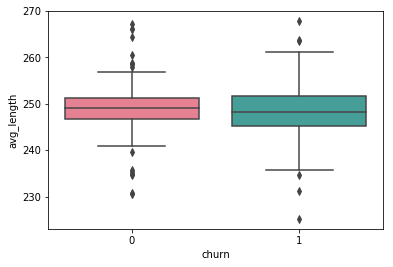

In [114]:
box_plot(user_df,'avg_length')
t_test(user_df,'avg_length','churn',True),t_test(user_df,'avg_length','churn',False)

Ttest_indResult(statistic=-2.3694782412455946, pvalue=0.018666181281982965)
Ttest_indResult(statistic=-3.0646048942493596, pvalue=0.0026108061807860912)


(None, None)

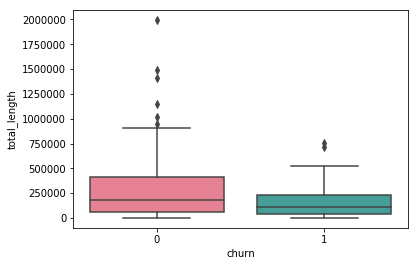

In [115]:
box_plot(user_df,'total_length')
t_test(user_df,'total_length','churn',True),t_test(user_df,'total_length','churn',False)

### 3.3 Conclusion
In this session we engineered some potentially important features, plot the comparisons and perform preliminary statistical analysis. 
<br>Here are a few takehomes:
1. Cancel_count is not a valid parameter. Originally I thought it might be different from cancel_confirmation count but it's essentially the same
<br>
<br>
2. gender and level are weak predictors but worth included in final model. The figures show some difference but not in stats. As t_test is not the best option for binary data and I'm only doing preliminary analysis here, I decide to include them in the model. 
<br>
<br>
3. Location will not be included in the final model. Although didn't perform stats analysis, it shows very large variances so not likely to provide good predicting power. This feature could be explored more in more sophisticated models in the future. 
<br>
<br>
4. reg_days, max_gap, session_count and artist_count, avg_session_items, and total_length are strong predictors and will be included in final model, as indicated by stats results 
<br>
<br>
5. session_freq and avg(length) are probably not predictors. They didn't show any stats power even with large sample size. So in the first version of model I would not include them 

# 4. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 4.1 Engineer features (continued)
We have engineered the following features in section 3.2.1 and filtered some out, here are the remaining feature list:
1. artist count
2. song count 
3. largest gap between visits  
4. session counts 
5. gender 
6. level 
7. total length of visit (total_length)
8. total registration days (reg_days) 
9. average session item count (avg_session_items)

Here are more features I haven't explored but might be good predictors:
<br>
page viewing frequency 

In [27]:
# page view frequency 
df_page=df.groupBy('userId').pivot('page').count().na.fill(0).drop('Cancellation Confirmation','Cancel')
df_page_total=df.filter("page != 'Cancellation Confirmation' and page != 'Cancel'" ).groupBy('userId').count()
df_page=df_page.join(df_page_total,['userId'])

cols=df_page.columns
cols=[column for column in cols if column not in ('userId', 'count')]

for s in cols:
    df_page = df_page.withColumn(s, col(s)/col('count'))

user_df = user_df.join(df_page,["userId"])

In [28]:
# data is ready for the model 
user_df = user_df.drop('se_freq','avg_length','location','cancel_count')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- avg(length): double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- total_length: double (nullable = true)
 |-- max_gap: double (nullable = true)
 |-- reg_days: double (nullable = true)
 |-- avg_session_items: double (nullable = true)
 |-- sum_length: double (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: 

# 5. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 5.1 split data into train and test data set 

In [29]:
user_df = user_df.drop('userId')
#user_df.write.save("user_df.csv",format = "csv",header = True)
features = [col for col in user_df.columns if col!='churn'] 
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

### 5.2 Model fitting

In [30]:
def model_pipeline(classifier, params):
    """
    Build model pipline 
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [31]:
# logistic regression 
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [32]:
fit_model_lr = model_lr.fit(train)

In [33]:
pred_lr = fit_model_lr.transform(test)

In [34]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
print("f1 using Logistic Regression: {}".format(f1_score))

f1 using Logistic Regression: 0.7545523690215203


In [52]:
#random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [53]:
fit_model_rf = model_rf.fit(train)

In [54]:
pred_rf = fit_model_rf.transform(test)

In [56]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
print("f1 using Random Forest: {}".format(f1_score_rf))

f1 using Random Forest: 0.6376243593608683


In [ ]:
# gradient boost
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [ ]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

In [58]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(gbt_f1_score))

f1 using Gradient Boosting: 0.6361847158218126


In [71]:
# Decision Tree
dt =DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [72]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [73]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
print("f1 using Gradient Boosting: {}".format(dt_f1_score))

f1 using Gradient Boosting: 0.6477108967963641


### 5.3 Hyper parameter tuning 


In [96]:
classifier = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
lr =  LogisticRegression(labelCol="label", featuresCol="features")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()
model_tuned = model_pipeline(classifier, paramGrid_lr)

In [97]:
fit_model_tuned = model_tuned.fit(train)
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [98]:
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1 using tuned RF: {}".format(best_f1_score))

f1 using tuned RF: 0.7545523690215203


### 5.4 Feature importance rank

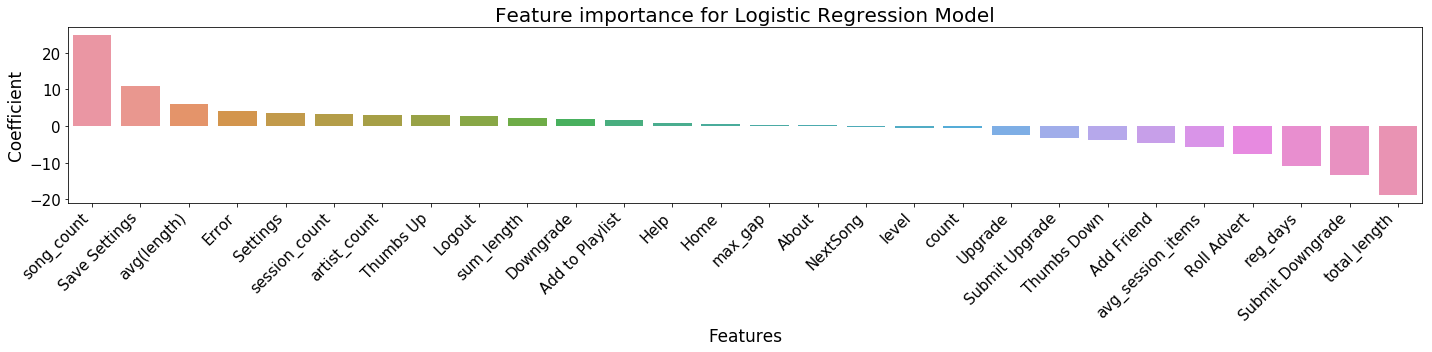

In [101]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.